# Building the Predictive Model

In [42]:
from scripts.mouse import Mouse

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Loading Data

In [44]:
# Now we can group the data by mouse

cori = [Mouse(i) for i in range(1, 4)]
forssmann = [Mouse(i) for i in range(4, 8)]
hench = [Mouse(i) for i in range(8, 12)]
lederberg = [Mouse(i) for i in range(12, 19)]

mice = [cori, forssmann, hench, lederberg]

In [45]:
# Gather model features for all sessions.

global_features = pd.DataFrame()
for mouse in mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

In [46]:
global_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,ACB,AUD,BLA,CA1,...,VISa,VISam,VISl,VISp,VISpm,VISrl,VPL,VPM,ZI,root
0,Cori,1,1,2,1.0,1.266055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.685393,0.0,0.0,0.0,0.0,0.0,0.500000
1,Cori,1,2,3,1.0,0.587156,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.651685,0.0,0.0,0.0,0.0,0.0,0.666667
2,Cori,1,3,2,-1.0,1.192661,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.275281,0.0,0.0,0.0,0.0,0.0,1.444444
3,Cori,1,4,3,-1.0,0.513761,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.561798,0.0,0.0,0.0,0.0,0.0,1.055556
4,Cori,1,5,3,-1.0,0.770642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.623596,0.0,0.0,0.0,0.0,0.0,0.777778


We may be able to reduce overfitting if we filter out the brain areas that provide little information.

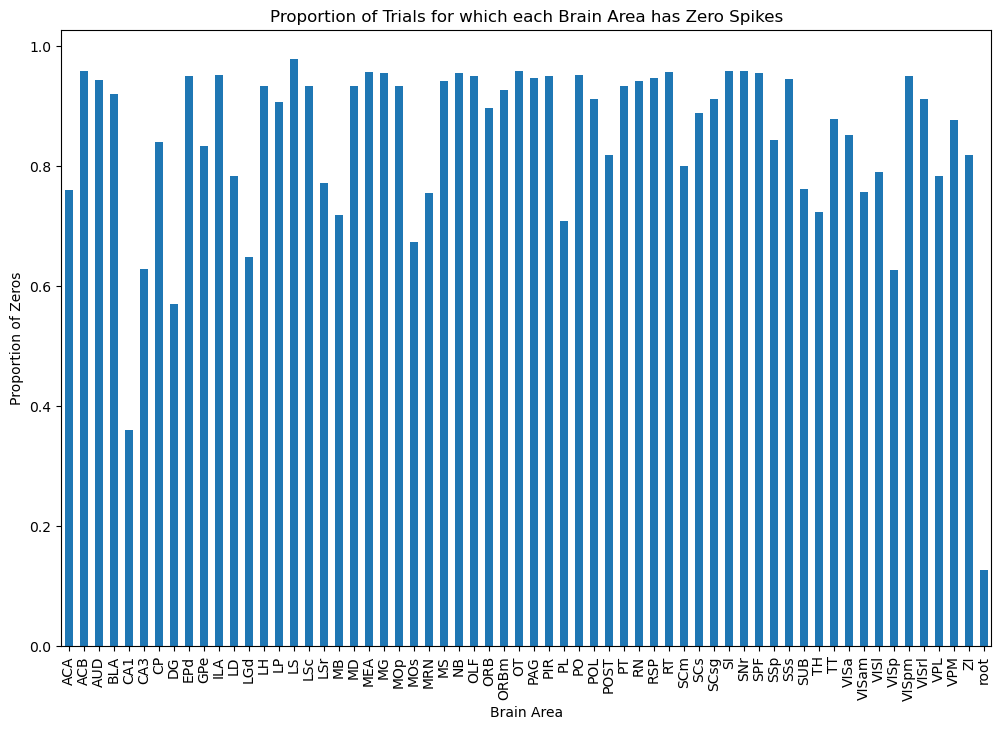

In [47]:
# Calculate the proportion of zeros for each brain area column
proportion_zeros = (global_features[brain_areas] == 0).mean()

# Plot the proportion of zeros
plt.figure(figsize=(12, 8))
proportion_zeros.plot(kind='bar')
plt.title('Proportion of Trials for which each Brain Area has Zero Spikes')
plt.xlabel('Brain Area')
plt.ylabel('Proportion of Zeros')
plt.savefig('./figures/features_by_null_proportion.png')
plt.show()

In [48]:
# Filter columns based on proportion_zeros
filtered_columns = proportion_zeros[proportion_zeros < 0.9].index.tolist()
filtered_columns = metadata + filtered_columns
filtered_features = global_features[filtered_columns]
filtered_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,CA1,CA3,CP,DG,...,TH,TT,VISa,VISam,VISl,VISp,VPL,VPM,ZI,root
0,Cori,1,1,2,1.0,1.266055,0.0,1.529412,0.0,2.323529,...,0.0,0.0,0.0,0.0,0.0,1.685393,0.0,0.0,0.0,0.500000
1,Cori,1,2,3,1.0,0.587156,0.0,1.705882,0.0,1.558824,...,0.0,0.0,0.0,0.0,0.0,1.651685,0.0,0.0,0.0,0.666667
2,Cori,1,3,2,-1.0,1.192661,0.0,1.985294,0.0,3.411765,...,0.0,0.0,0.0,0.0,0.0,2.275281,0.0,0.0,0.0,1.444444
3,Cori,1,4,3,-1.0,0.513761,0.0,2.191176,0.0,2.205882,...,0.0,0.0,0.0,0.0,0.0,1.561798,0.0,0.0,0.0,1.055556
4,Cori,1,5,3,-1.0,0.770642,0.0,1.808824,0.0,2.058824,...,0.0,0.0,0.0,0.0,0.0,1.623596,0.0,0.0,0.0,0.777778


In [49]:
filtered_features.columns

Index(['Mouse', 'Session', 'Trial', 'Decision', 'Feedback', 'ACA', 'CA1',
       'CA3', 'CP', 'DG', 'GPe', 'LD', 'LGd', 'LSr', 'MB', 'MOs', 'MRN', 'ORB',
       'PL', 'POST', 'SCm', 'SCs', 'SSp', 'SUB', 'TH', 'TT', 'VISa', 'VISam',
       'VISl', 'VISp', 'VPL', 'VPM', 'ZI', 'root'],
      dtype='object')

# Model Selection

**First, train models on the full data set**

In [50]:
X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=0
)

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "="*60 + "\n")

Model: Logistic Regression
Accuracy: 0.7129
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.31      0.01      0.03       287
         1.0       0.72      0.99      0.83       730

    accuracy                           0.71      1017
   macro avg       0.51      0.50      0.43      1017
weighted avg       0.60      0.71      0.60      1017

Confusion Matrix:
[[  4 283]
 [  9 721]]


Model: Random Forest
Accuracy: 0.6903
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.40      0.20      0.27       287
         1.0       0.74      0.88      0.80       730

    accuracy                           0.69      1017
   macro avg       0.57      0.54      0.53      1017
weighted avg       0.64      0.69      0.65      1017

Confusion Matrix:
[[ 57 230]
 [ 85 645]]


Model: Support Vector Machine
Accuracy: 0.7198
Classification Report:
              precision    recall  f1-score   support

       

The random forest appears to have done the best, though not by much.

In [51]:
# Retrain the random forest model on the entire data set
random_forest = RandomForestClassifier()
random_forest.fit(X_scaled, y)

# Save the trained model to a file
joblib.dump(random_forest, 'primary_random_forest_model.pkl')

['primary_random_forest_model.pkl']

**Next, perform Principal Component Analysis**

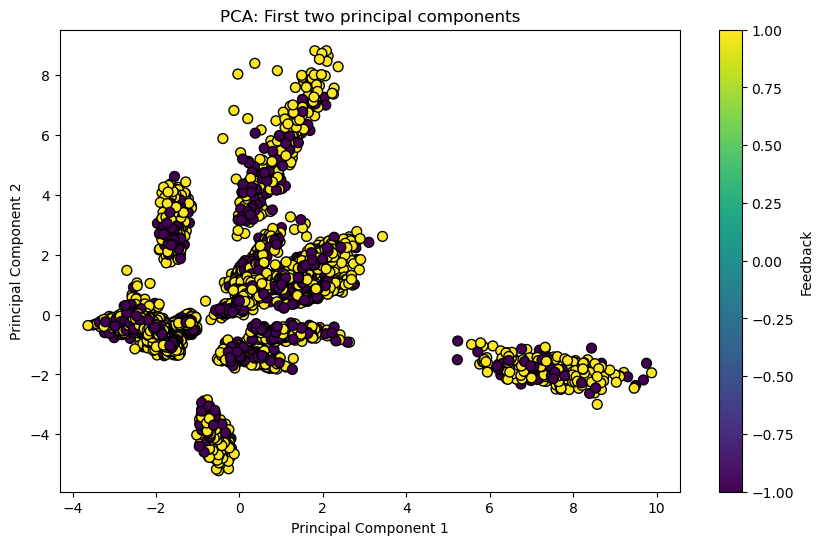

In [52]:
X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

pca = PCA(n_components=None)
principal_components = pca.fit_transform(X_scaled)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=y,
    cmap="viridis",
    edgecolor="k",
    s=50,
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.colorbar(label='Feedback')
plt.savefig('./figures/pca.png')
plt.show()

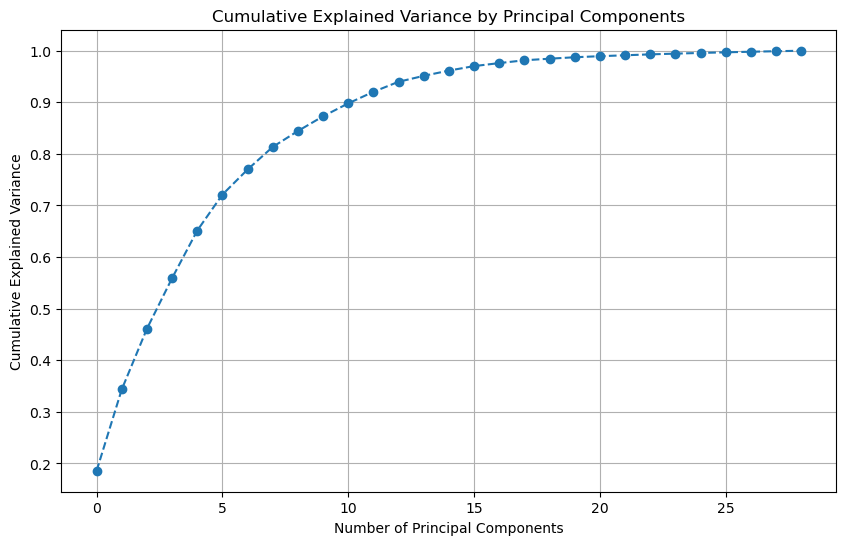

In [53]:
# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.savefig('./figures/global_cumulative_explained_variance.png')
plt.show()

**PCA on the Global Dataset** - for comparison.

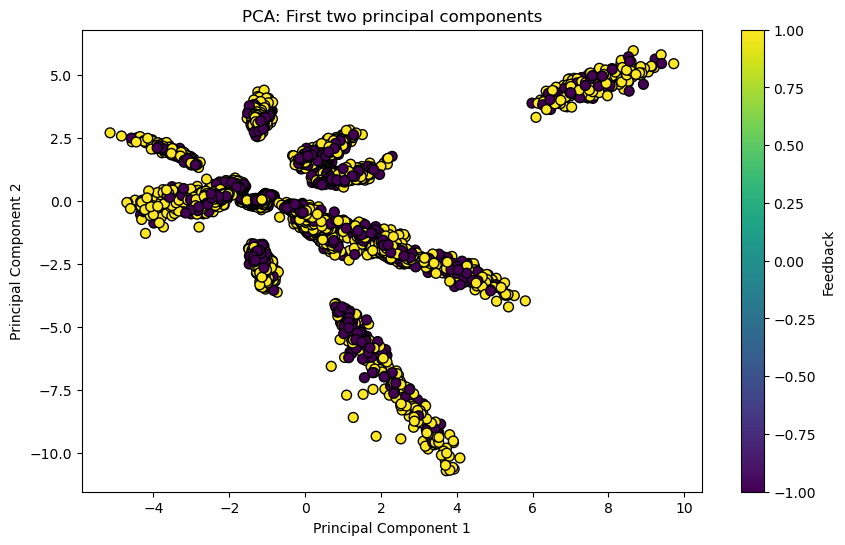

In [56]:
X_global = global_features.drop(columns=['Feedback', 'Mouse', 'Session'])
y_global = global_features['Feedback']

# Standardize the features
scaler_global = StandardScaler()
X_global_scaled = scaler_global.fit_transform(X_global)

pca_global = PCA(n_components=None)
principal_components_global = pca_global.fit_transform(X_global_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(
    principal_components_global[:, 0],
    principal_components_global[:, 1],
    c=y_global,
    cmap="viridis",
    edgecolor="k",
    s=50,
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.colorbar(label='Feedback')
plt.show()

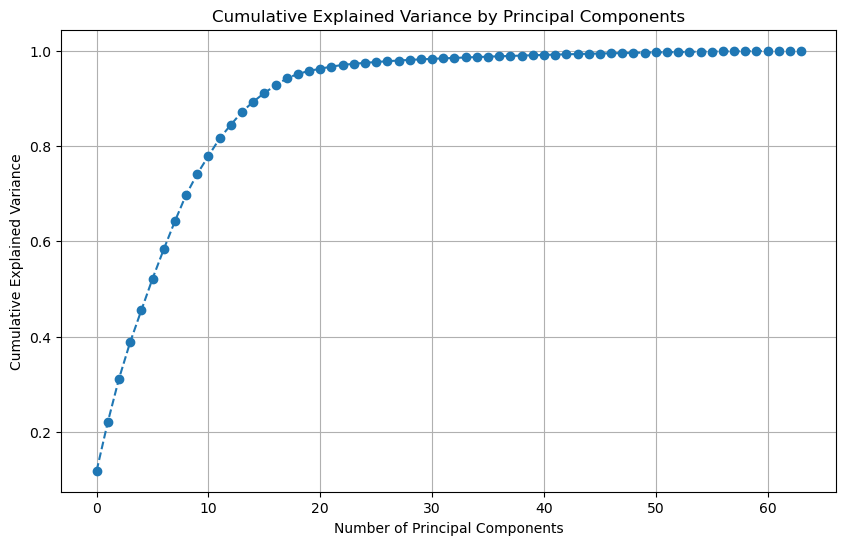

Accuracy: 0.7286
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.55      0.23      0.32       287
         1.0       0.75      0.93      0.83       730

    accuracy                           0.73      1017
   macro avg       0.65      0.58      0.58      1017
weighted avg       0.69      0.73      0.69      1017

Confusion Matrix:
[[ 65 222]
 [ 54 676]]


In [ ]:
cumulative_explained_variance_global = pca_global.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance_global, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Use the principal components to train a model to predict 'Feedback'
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    principal_components_global,
    y_global,
    test_size=0.2,
    random_state=0
)

# Train and evaluate a Random Forest model
random_forest_global = RandomForestClassifier()
random_forest_global.fit(X_train_global, y_train_global)
y_pred_global = random_forest_global.predict(X_test_global)

print(f"Accuracy: {accuracy_score(y_test_global, y_pred_global):.4f}")
print("Classification Report:")
print(classification_report(y_test_global, y_pred_global))
print("Confusion Matrix:")
print(confusion_matrix(y_test_global, y_pred_global))